Aca vamos a hacer la parte de generacion y evaluacion de modelos

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 

from scripts import mejor_featurer


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, recall_score, accuracy_score,precision_score ,f1_score

In [2]:
df = pd.read_csv("C:/Users/mlard/OneDrive/Escritorio/Mateo/Org de Datos/tp3Github/Org-Datos-Grupo-19/dataset-procesado.csv", index_col=False)

In [3]:
df_trabajo = mejor_featurer.featurizer(df)

-------


In [4]:
df_trabajo.shape

(263965, 138)

In [232]:
df_trabajo.columns

Index(['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'D_43', 'D_44',
       'B_4',
       ...
       'D_63_CR', 'D_63_XL', 'D_63_XM', 'D_63_XZ', 'customer_id_repeat_size',
       'd_feats_mean', 's_feats_mean', 'p_feats_mean', 'b_feats_mean',
       'r_feats_mean'],
      dtype='object', length=138)

In [6]:
#Separo en train y test para trabajar los modelos
df_trabajo_x=df_trabajo.drop(['target'], axis='columns', inplace=False)

df_trabajo_y = df_trabajo['target'].copy()
#Uso parametro stratify para balancear el target dentro de cada ser de datos de train test
x_train, x_test, y_train, y_test = train_test_split(df_trabajo_x, df_trabajo_y, test_size=0.3, random_state=1, stratify = df_trabajo_y)

Modelo Random forest

Buscamos los mejores hiperparametros para el modelo Random forest

In [7]:
rf_cv = RandomForestClassifier(random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], 
               "min_samples_leaf" : [1, 5], 
               "max_features":["sqrt", "log2"],
               "min_samples_split" : [2, 5], 
               "n_estimators": [10,50] }

#Probamos entrenando sólo con 1 métrica
gs = GridSearchCV(estimator=rf_cv, param_grid=param_grid, scoring="roc_auc", cv=5, n_jobs=-1)

In [8]:
gs_fit = gs.fit(X = x_train, y = y_train)
best_params_rfc = gs_fit.best_params_

print(best_params_rfc)

{'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50}


Predecimos utilizando el mejor modelo q obtuvimos

In [9]:
rfc_best_model = RandomForestClassifier(**best_params_rfc)

In [10]:
model_rfc = rfc_best_model.fit(X = x_train,y = y_train)
y_pred_rfc = model_rfc.predict(x_test)
df_resultados_rfc=pd.DataFrame(zip(y_test,y_pred_rfc),columns=['test','predicted'])

In [13]:
df_resultados_rfc.sample(5)

,test,predicted
56615,1,1
31293,0,0
68228,0,0
49001,0,0
71807,0,0


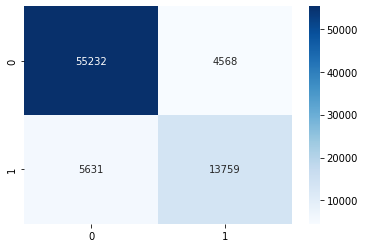

In [14]:
tabla=confusion_matrix(df_resultados_rfc['test'], df_resultados_rfc['predicted'])

grf=sns.heatmap(tabla,cmap='Blues',annot=True,fmt='g')
plt.show()

In [15]:
def results_comparation(df_predict):
    df_predict["success"] = (df_predict["test"] == df_predict["predicted"])
    df_predict["success"].value_counts().plot.pie(autopct='%1.1f%%')
    plt.title("Cantidad de valores predecidos correctamente") 
    plt.show()

    precicion = precision_score(df_predict['test'], df_predict['predicted'])
    f1=f1_score(df_predict['test'], df_predict['predicted'])
    recall = recall_score(df_predict['test'], df_predict['predicted'])
    
    print(f"Precision score: \t{round(precicion,3)}")
    print(f"Recall score: \t\t{round(recall,3)}")
    print(f"F1 score: \t\t{round(f1,3)}")

    accuracy=accuracy_score(df_predict['test'], df_predict['predicted'], normalize=True)
    print("Tiene una accuracy del: " + str(round(accuracy, 3)) + "% como muestra el pie chart")


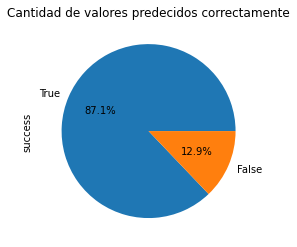

Precision score: 	0.751
Recall score: 		0.71
F1 score: 		0.73
Tiene una accuracy del: 0.871% como muestra el pie chart


In [16]:
results_comparation(df_resultados_rfc)

Modelo XGBoost

In [17]:
import xgboost as xgb
import sklearn
from xgboost.sklearn import XGBClassifier

In [18]:
# df_featurizado = featurizer_xgb.featurizer(df_trabajo)
df_featurizado = df_trabajo

In [19]:
X_xgb = df_featurizado.drop(axis = 1, columns = ['target'])
y_xgb = df_featurizado.target

features = X_xgb.columns

In [20]:
xgb = XGBClassifier()

In [21]:
#Set hyperparameters dictionary
param_dist = {'n_estimators':[50, 100],
              'max_depth':[5,10],              
              'subsample': [0.5,0.8,1],
              'colsample_bytree': [0.5,0.8,1],              
              'learning_rate':[0.01, 0.1, 0.3]
              }

In [22]:
random_search_xgb = RandomizedSearchCV(xgb,
                                       param_distributions = param_dist,
                                       n_iter = 2,
                                       scoring = 'roc_auc',
                                       cv = 5,
                                       n_jobs = -1,
                                       verbose=5)

In [23]:
%time
random_search_xgb.fit(x_train, y_train)

CPU times: total: 0 ns
Wall time: 984 µs
Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.8, 1],
                                        'learning_rate': [0.01, 0.1, 0.3],
                                        'max_depth': [5, 10],
                                        'n_estimators': [50, 100],
                                        'subsample': [0.5, 0.8, 1]},
                   scoring='roc_auc', verbose=5)

In [24]:
params_opt_xgb = random_search_xgb.best_params_

In [25]:
params_opt_xgb

{'subsample': 0.8,
 'n_estimators': 100,
 'max_depth': 5,
 'learning_rate': 0.1,
 'colsample_bytree': 0.5}

In [26]:
xgbModelBestParams = XGBClassifier(**params_opt_xgb)

In [27]:
%time
model_xgb = xgbModelBestParams.fit(X = x_train,y = y_train)
y_pred_xgb = model_xgb.predict(x_test)
df_resultados_xgb=pd.DataFrame(zip(y_test,y_pred_xgb),columns=['test','predicted'])

CPU times: total: 0 ns
Wall time: 0 ns


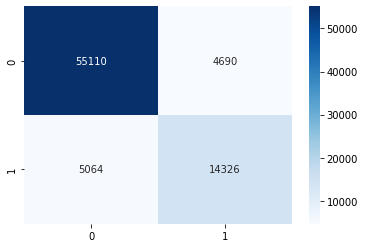

In [28]:
tabla=confusion_matrix(df_resultados_xgb['test'], df_resultados_xgb['predicted'])

grf=sns.heatmap(tabla,cmap='Blues',annot=True,fmt='g')
plt.show()

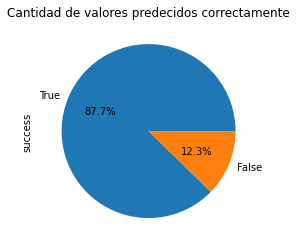

Precision score: 	0.753
Recall score: 		0.739
F1 score: 		0.746
Tiene una accuracy del: 0.877% como muestra el pie chart


In [29]:
results_comparation(df_resultados_xgb)

Suport Vector Machine

Hicimos el analisis del suport vector machine, pero genera muchos problemas y aparte tiene uy poca precicion
(German aca pone lo que hiciste de SVM)

Ensamble de modelos

In [30]:
from sklearn.ensemble import VotingClassifier

In [31]:
vot_clf = VotingClassifier(estimators = [('rnd', rfc_best_model),('xgb', xgbModelBestParams)], voting = 'hard')

In [32]:
vot_clf.fit(x_train, y_train)
pred_vot_clf = vot_clf.predict(x_test)

df_resultados_vot_clf=pd.DataFrame(zip(y_test,pred_vot_clf),columns=['test','predicted'])

Tabla de confusion de test: 


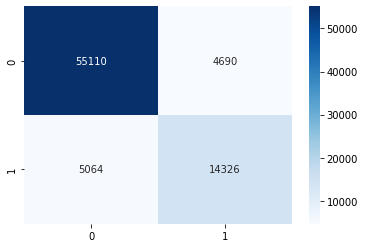

In [33]:
tabla=confusion_matrix(df_resultados_xgb['test'], df_resultados_xgb['predicted'])

print('Tabla de confusion de test: ')

grf=sns.heatmap(tabla,cmap='Blues',annot=True,fmt='g')
plt.show()

Tabla de confusion de entrenamiento: 


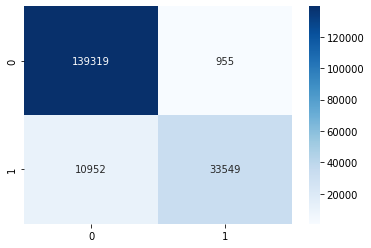

In [34]:
y_train_vot_clf = vot_clf.predict(x_train)
tabla=confusion_matrix(y_train, y_train_vot_clf)
print('Tabla de confusion de entrenamiento: ')
grf=sns.heatmap(tabla,cmap='Blues',annot=True,fmt='g')
plt.show()

In [35]:
print("Accuracy de entrenamiento : ", accuracy_score(y_train, y_train_vot_clf))
print("Accuracy de test : ", accuracy_score(df_resultados_vot_clf['test'], df_resultados_vot_clf['predicted']))
print('\n')
print('Se puede ver que la precicion para el voting classifier no tiene overfitting ni underfitting')

Accuracy de entrenamiento :  0.9355594642132323
Accuracy de test :  0.8735572673317338


Se puede ver que la precicion para el voting classifier no tiene overfitting ni underfitting


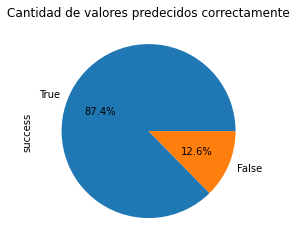

Precision score: 	0.773
Recall score: 		0.684
F1 score: 		0.726
Tiene una accuracy del: 0.874% como muestra el pie chart


In [36]:
results_comparation(df_resultados_vot_clf)

Se puede ver que el voting classifier es el que mas precicion tiene, comparandolos con los modelos RandomForest y XGBoost.

Redes neuronales

In [47]:
import pandas as pd
import numpy as np

import tensorflow
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


from sklearn.model_selection import train_test_split, GridSearchCV


import sys
sys.path.append('../')
from scripts import featurizer_rn


%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'tensorflow.python'

In [ ]:
X, Y = featurizer_rn.featurizer(df)

In [ ]:
dataset = X.values

In [ ]:
Y

In [ ]:
X = dataset.astype(float)
y = Y

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)

In [ ]:
for train, test in kfold.split(X, y):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]

In [ ]:
X.shape[0]

In [ ]:
X_train.shape[0]/X.shape[0]

In [ ]:
X_test.shape[0]/X.shape[0]

In [ ]:
# baseline model
def create_baseline(input_dim, opt):
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=input_dim, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation="sigmoid"))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])
    return model

In [ ]:
from keras.optimizers import SGD
opt = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model_baseline = create_baseline(X_train.shape[1],opt)

In [ ]:
model_baseline.fit(X_train, y_train, epochs=1000, verbose=1, batch_size=100,validation_split=0.2)

In [ ]:
scores_train = model_baseline.evaluate(X_train, y_train)
print("\n%s: %.2f%%" % (model_baseline.metrics_names[1], scores_train[1]*100))

In [ ]:
scores_test = model_baseline.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model_baseline.metrics_names[1], scores_test[1]*100))

Ensamble Cascading

In [49]:
df_resultados_rfc.sample()

,test,predicted,success
65711,0,0,True


In [50]:
df_resultados_rfc['success'][79187]

True

In [51]:
df_resultados_rfc['success']

0        True
1        True
2        True
3        True
4        True
         ... 
79185    True
79186    True
79187    True
79188    True
79189    True
Name: success, Length: 79190, dtype: bool

In [237]:
def df_con_casos_no_detectados(df_train, pred_train, train_original):
    df_train['target_pred'] = pred_train
    df_train['target_original'] = train_original
    df_errores = df_train[df_train['target_pred'] != df_train['target_original']]
    df_target = pd.DataFrame(df_errores['target_original'])
    # df_target.shape
    # df_target.sample()
    df_errores = df_errores.drop(['target_pred', 'target_original'],axis=1)
    # display(df_errores)
    # print('\n\n')
    # display(df_target)
    return df_errores, df_target

In [236]:
df_prueba = df_trabajo.sample(10000)
df_prueba_x=df_prueba.drop(['target'], axis='columns', inplace=False)

df_prueba_y = df_prueba['target'].copy()
# Uso parametro stratify para balancear el target dentro de cada ser de datos de train test
x_train_prueba, x_test_prueba, y_train_prueba, y_test_prueba = train_test_split(df_prueba_x, df_prueba_y, test_size=0.3, random_state=1, stratify = df_prueba_y)

In [132]:
#Probamos la funcion
# model = rfc_best_model
# # display(x_train_prueba)
# model_rfc = rfc_best_model.fit(X = x_train_prueba,y = y_train_prueba)
# y_pred_model_prueba = model.predict(x_train_prueba)
# df_pruebax, df_target_prueba = df_con_casos_no_detectados(x_train_prueba, y_pred_model_prueba, y_train_prueba)

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,D_43,D_44,B_4,...,D_63_CR,D_63_XL,D_63_XM,D_63_XZ,customer_id_repeat_size,d_feats_mean,s_feats_mean,p_feats_mean,b_feats_mean,r_feats_mean
161208,0.518904,0.003633,0.009937,0.811557,0.008233,0.225781,0.005466,0.224558,0.006903,0.003803,...,0,0,0,0,1,0.324212,0.195512,0.347950,0.154354,0.170743
170269,0.538404,0.006217,-0.026456,0.816678,0.006044,0.225781,0.002793,0.058277,0.127810,0.097035,...,0,0,0,0,2,0.292350,0.194350,0.463949,0.121808,0.096897
26150,0.897521,0.534682,0.136000,0.313451,0.009675,0.129975,0.860821,0.153998,0.133616,0.393764,...,1,0,0,0,2,0.373702,0.332023,0.515250,0.249522,0.091614
112175,0.562577,0.006278,0.004291,0.812062,0.009084,0.208711,0.000688,0.264198,0.005674,0.103394,...,0,0,0,0,1,0.271015,0.225874,0.411652,0.152194,0.153732
107820,0.733830,0.003904,0.003422,0.817782,0.003050,0.433379,0.002911,0.123349,0.004841,0.174019,...,0,0,0,0,2,0.183170,0.242510,0.491823,0.182107,0.100692
43747,0.652719,0.177131,0.022038,1.007555,0.006741,0.085175,0.003543,0.450374,0.004281,0.017083,...,0,0,0,0,1,0.391642,0.330309,0.467923,0.207918,0.155712
93520,0.219548,0.181168,0.227063,0.115197,0.007694,0.273992,0.446577,0.153998,0.118615,0.150307,...,0,0,0,0,2,0.454147,0.112128,0.353948,0.224716,0.060462
167636,0.564769,0.500592,0.014262,0.812715,0.004367,0.299729,0.004714,0.090193,0.001005,0.137812,...,0,0,0,0,2,0.216317,0.194294,0.548052,0.126043,0.096514
131292,0.766385,0.268894,0.338972,0.024892,0.009791,0.331124,0.000509,0.101462,0.008659,0.130958,...,0,0,0,0,1,0.240184,0.247776,0.479945,0.173867,0.097327
115233,0.427633,0.034568,0.221412,0.028545,0.505045,0.156498,0.005839,0.113657,0.505430,0.685322,...,0,0,0,0,1,0.197052,0.138480,0.323470,0.235136,0.156821


,target_original
161208,1
170269,1
26150,1
112175,1
107820,1
43747,1
93520,0
167636,1
131292,1
115233,0


In [213]:
# df_cascading = mejor_featurer.featurizer(df)
# df_cascading_x=df_cascading.drop(['target'], axis='columns', inplace=False)

# df_cascading_y = df_cascading['target'].copy()

-------


In [223]:
def ensamble_cascading(df_cascada, model):
    df_cascada_x =df_cascada.drop(['target'], axis='columns', inplace=False)
    df_cascada_y = df_cascada['target'].copy()

    x_train_cascada, y_train_cascada,x_test_cascada,y_train_cascada = train_test_split(df_cascada_x, df_cascada_y, test_size=0.3, random_state=1)
    model = type_model.fit(X = x_train_cascada,y = y_train_cascada)
    y_pred_model_train = model.predict(x_train_cascada)
    x_train_cascada, y_train_cascada = df_con_casos_no_detectados(x_train_cascada, y_pred_model_train, y_train_cascada)
    print('\nLlego\n')
    return x_train_cascada, y_train_cascada


In [239]:
#Forma de un cascading
models = list()
models.append(rfc_best_model)
models.append(xgbModelBestParams)
#Falta agregar l modelo redes neuronales
# df_cascada = df_prueba.sample(10000)
# cantidad_de_filas = x_train_prueba.shape[0]
x_train_cascada = x_train_prueba
y_train_cascada = y_train_prueba
for type_model in models:
    
    # x_train_cascada, y_train_cascada = ensamble_cascading(df_cascada, type_model)

    # x_train_cascada['target'] = y_train_cascada
    # df_cascada = x_train_cascada

    # display(df_cascada)

    model = type_model.fit(X = x_train_cascada,y = y_train_cascada)
    y_pred_model_train = model.predict(x_train_cascada)
    x_train_cascada, y_train_cascada = df_con_casos_no_detectados(x_train_cascada, y_pred_model_train, y_train_cascada)
    
    # display(x_train_cascade.shape)

y_pred_cascade = model.predict(x_test_prueba)
df_resultados_cascade=pd.DataFrame(zip(y_test_prueba,y_pred_cascade),columns=['test','predicted'])


# cantidad_de_filas_sin_predecir = x_train_cascade.shape[0]
# porcentaje_sin_predecir = (cantidad_de_filas_sin_predecir/cantidad_de_filas) * 100
# print('A travez del ensamble cascada se predijo el ',(100 - porcentaje_sin_predecir),  '% correctamente')
    

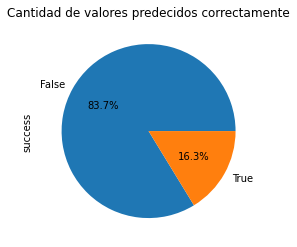

Precision score: 	0.149
Recall score: 		0.524
F1 score: 		0.232
Tiene una accuracy del: 0.163% como muestra el pie chart


In [240]:
results_comparation(df_resultados_cascade)